In [ ]:
# technical_indicators_final.py
import warnings, yfinance as yf
from itertools import product
from joblib import Parallel, delayed
from sklearn.model_selection import ParameterSampler
from dateutil.relativedelta import relativedelta

import numpy as np
import pandas as pd

warnings.filterwarnings("ignore", category=RuntimeWarning)

# --------------------------------------------------
# 1. Download Price Data
# --------------------------------------------------
def download_prices(ticker, start="2010-01-01"):
    df = yf.download(ticker, start=start, auto_adjust=True, progress=False)[['Close']]
    df.dropna(inplace=True)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    return df

# --------------------------------------------------
# 2. Indicator Functions
# --------------------------------------------------
def compute_rsi(close, window):
    delta = close.diff()
    gain  = delta.clip(lower=0)
    loss  = -delta.clip(upper=0)
    avg_g = gain.ewm(alpha=1/window, min_periods=window).mean()
    avg_l = loss.ewm(alpha=1/window, min_periods=window).mean()
    rs = avg_g / (avg_l + 1e-10)
    return 100 - 100/(1 + rs)

def compute_macd(close, fast, slow, signal_smooth):
    ema_f = close.ewm(span=fast, adjust=False).mean()
    ema_s = close.ewm(span=slow, adjust=False).mean()
    macd  = ema_f - ema_s
    signal = macd.ewm(span=signal_smooth, adjust=False).mean()
    return macd, signal

def compute_vol(close, window):
    return close.pct_change().rolling(window).std()

def compute_bb(close, window):
    ma = close.rolling(window).mean()
    sd = close.rolling(window).std()
    return (close - ma) / (sd + 1e-10)

def rolling_zscore(series, window):
    m = series.rolling(window).mean()
    s = series.rolling(window).std()
    return (series - m) / (s + 1e-10)

# --------------------------------------------------
# 3. Signal Generators
# --------------------------------------------------
def generate_stateful_signal(z, long_thr, short_thr, exit_long=0.0, exit_short=0.0):
    sig, state = pd.Series(0, index=z.index), 0
    prev = z.shift(1)

    for t in z.index:
        c, p = z.at[t], prev.at[t]
        if pd.isna(c) or pd.isna(p):
            sig.at[t] = state
            continue

        if state == 0:
            if p >= long_thr and c < long_thr:
                state = 1
            elif p <= short_thr and c > short_thr:
                state = -1

        elif state == 1:
            if c > short_thr:
                state = -1
            elif c >= exit_long:
                state = 0

        elif state == -1:
            if c < long_thr:
                state = 1
            elif c <= exit_short:
                state = 0

        sig.at[t] = state

    return sig.astype(int)

# def get_macd_stateful_signal(macd, sigline, exit_long=0.0, exit_short=0.0):
#     signal = pd.Series(0, index=macd.index)
#     state = 0

#     for t in range(1, len(macd)):
#         prev_macd, curr_macd = macd.iloc[t-1], macd.iloc[t]
#         prev_sig, curr_sig = sigline.iloc[t-1], sigline.iloc[t]

#         if state == 0:
#             if prev_macd <= prev_sig and curr_macd > curr_sig:
#                 state = 1
#             elif prev_macd >= prev_sig and curr_macd < curr_sig:
#                 state = -1

#         elif state == 1:
#             if curr_macd < exit_long:
#                 state = 0

#         elif state == -1:
#             if curr_macd > exit_short:
#                 state = 0

#         signal.iloc[t] = state
#     return signal.astype(int)
def get_macd_stateful_signal(macd, sigline):
    """
    Entry:   Long when MACD crosses above signal line
             Short when MACD crosses below signal line
    Exit:    Exit long if MACD crosses below signal line again
             Exit short if MACD crosses above signal line again
    """
    signal = pd.Series(0, index=macd.index)
    state = 0

    for t in range(1, len(macd)):
        prev_macd, curr_macd = macd.iloc[t-1], macd.iloc[t]
        prev_sig, curr_sig = sigline.iloc[t-1], sigline.iloc[t]

        # Long entry
        if state == 0 and prev_macd <= prev_sig and curr_macd > curr_sig:
            state = 1
        # Short entry
        elif state == 0 and prev_macd >= prev_sig and curr_macd < curr_sig:
            state = -1
        # Exit long
        elif state == 1 and prev_macd >= prev_sig and curr_macd < curr_sig:
            state = 0
        # Exit short
        elif state == -1 and prev_macd <= prev_sig and curr_macd > curr_sig:
            state = 0

        signal.iloc[t] = state

    return signal.astype(int)
# --------------------------------------------------
# 4. Backtest Function
# --------------------------------------------------
def backtest(df, signal, fee_per_day=0.001):
    signal = signal.reindex(df.index).fillna(0).astype(int)
    close = df['Close']
    ret = close.pct_change().fillna(0)

    pos = signal.shift(1).fillna(0).astype(int)
    daily_ret = pos * ret
    entries = (pos != pos.shift(1)) & (pos != 0)
    daily_ret[entries] -= fee_per_day

    equity_curve = (1 + daily_ret).cumprod()
    total_return = equity_curve.iloc[-1] - 1
    days = len(df)
    cagr = equity_curve.iloc[-1] ** (252 / days) - 1 if days >= 30 else np.nan
    ann_vol = daily_ret.std() * np.sqrt(252)
    sharpe = (daily_ret.mean() / (daily_ret.std() + 1e-10)) * np.sqrt(252)
    max_dd = (equity_curve / equity_curve.cummax() - 1).min()
    entry_days = daily_ret[entries]
    hit_rate = (entry_days > 0).sum() / len(entry_days)

    changes = pos != pos.shift(1)
    dates = df.index[changes]
    vals = pos[changes]
    hold, prev, ent = [], 0, None
    for d, v in zip(dates, vals):
        if v != 0 and prev == 0:
            ent = d
        if v == 0 and prev != 0 and ent is not None:
            hold.append((d - ent).days)
            ent = None
        prev = v
    if prev != 0 and ent is not None:
        hold.append((df.index[-1] - ent).days)
    avg_hold = np.mean(hold) if hold else np.nan

    return {
        'Total Return': total_return,
        'CAGR': cagr,
        'Ann Vol': ann_vol,
        'Sharpe': sharpe,
        'Max Drawdown': max_dd,
        'Holding Days': avg_hold,
        'Total Trades': int(entries.sum()),
        'Hit Rate': hit_rate
    }

# --------------------------------------------------
# 5. Walk-Forward Evaluation
# --------------------------------------------------
param_grids = {
    'RSI': {
        'rsi_window': [10, 14],
        'long_z':     [-2.0, -1.5],
        'short_z':    [1.0, 1.5],
        'exit_long':  [0.0, -0.2],
        'exit_short': [0.0, -0.2]
    },
    'MACD': {
        'fast':          [12],
        'slow':          [26],
        'signal_smooth': [6, 9]
        # 'exit_long':     [0.0, -0.2],
        # 'exit_short':    [0.0, -0.2]
    },
    'Volatility': {
        'vol_window': [20, 30],
        'thr_window': [252],
        'long_z':     [-2.0],
        'short_z':    [2.0],
        'exit_long':  [0.0, -0.2],
        'exit_short': [0.0, -0.2]
    },
    'BollingerBands': {
        'window':     [20, 30],
        'long_z':     [-2.0],
        'short_z':    [2.0],
        'exit_long':  [0.0, -0.2],
        'exit_short': [0.0, -0.2]
    }
}


def process_ticker(ticker):
    df = download_prices(ticker)
    dates = df.index
    cache = {
        'RSI': {w: compute_rsi(df['Close'], w) for w in param_grids['RSI']['rsi_window']},
        'VOL': {w: compute_vol(df['Close'], w) for w in param_grids['Volatility']['vol_window']},
        'BB': {w: compute_bb(df['Close'], w) for w in param_grids['BollingerBands']['window']},
        'MACD': {}
    }
    for f in param_grids['MACD']['fast']:
        for s in param_grids['MACD']['slow']:
            for sm in param_grids['MACD']['signal_smooth']:
                cache['MACD'][(f, s, sm)] = compute_macd(df['Close'], f, s, sm)

    res = []
    train_start = dates.min()
    train_end = train_start + relativedelta(years=5) - pd.Timedelta(days=1)

    while True:
        train_start = train_end - relativedelta(years=5)+pd.Timedelta(days=1)
        test_start = train_end + pd.Timedelta(days=1)
        test_end = test_start + relativedelta(years=1) - pd.Timedelta(days=1)
        if test_start > dates.max(): break

        train_df = df.loc[train_start:train_end]
        test_df = df.loc[test_start:test_end]

        for strat, grid in param_grids.items():
            best_sh, best_p = -np.inf, None
            keys, values = zip(*grid.items())
            for p_vals in product(*values):
                p = dict(zip(keys, p_vals))
                if strat == 'RSI':
                    z = rolling_zscore(cache['RSI'][p['rsi_window']], 252)
                    sig = generate_stateful_signal(z, p['long_z'], p['short_z'], p['exit_long'], p['exit_short'])
                elif strat == 'MACD':
                    macd, sigline = cache['MACD'][(p['fast'], p['slow'], p['signal_smooth'])]
                    # sig = get_macd_stateful_signal(macd, sigline, p['exit_long'], p['exit_short'])
                    sig = get_macd_stateful_signal(macd, sigline)
                elif strat == 'Volatility':
                    vol_z = rolling_zscore(cache['VOL'][p['vol_window']], p['thr_window'])
                    sig = generate_stateful_signal(-vol_z, p['long_z'], p['short_z'], p['exit_long'], p['exit_short'])
                else:
                    bb_z = cache['BB'][p['window']]
                    sig = generate_stateful_signal(bb_z, p['long_z'], p['short_z'], p['exit_long'], p['exit_short'])

                stats = backtest(train_df, sig)
                if stats['Sharpe'] > best_sh:
                    best_sh, best_p = stats['Sharpe'], p.copy()

            # Test
            if strat == 'RSI':
                z = rolling_zscore(cache['RSI'][best_p['rsi_window']], 252)
                sig = generate_stateful_signal(z, best_p['long_z'], best_p['short_z'], best_p['exit_long'], best_p['exit_short'])
            elif strat == 'MACD':
                macd, sigline = cache['MACD'][(best_p['fast'], best_p['slow'], best_p['signal_smooth'])]
                # sig = get_macd_stateful_signal(macd, sigline, best_p['exit_long'], best_p['exit_short'])
                sig = get_macd_stateful_signal(macd, sigline)
            elif strat == 'Volatility':
                vol_z = rolling_zscore(cache['VOL'][best_p['vol_window']], best_p['thr_window'])
                sig = generate_stateful_signal(-vol_z, best_p['long_z'], best_p['short_z'], best_p['exit_long'], best_p['exit_short'])
            else:
                bb_z = cache['BB'][best_p['window']]
                sig = generate_stateful_signal(bb_z, best_p['long_z'], best_p['short_z'], best_p['exit_long'], best_p['exit_short'])

            stats = backtest(test_df, sig)
            stats.update({'Ticker': ticker, 'Strategy': strat,
                          'train_start': train_start.date(), 'train_end': train_end.date(),
                          'test_start': test_start.date(), 'test_end': test_end.date(),
                          **{f"best_{k}": v for k, v in best_p.items()}})
            res.append(stats)
        train_end = test_end
    return res

# --------------------------------------------------
# 6. Run All Tickers in Parallel
# --------------------------------------------------
if __name__ == "__main__":
    tickers = ['SOXX', 'XLF', 'XLV', 'XLRE', 'GDX', 'GUSH', 'FDN']
    nested = Parallel(n_jobs=-1)(delayed(process_ticker)(t) for t in tickers)
    all_results = [item for sublist in nested for item in sublist]
    df_results = pd.DataFrame(all_results).set_index(
        ['Ticker', 'Strategy', 'train_start', 'train_end', 'test_start', 'test_end']
    )
    print(df_results)


                                                                    Total Return  \
Ticker Strategy       train_start train_end  test_start test_end                   
SOXX   RSI            2010-01-04  2015-01-03 2015-01-04 2016-01-03     -0.021636   
       MACD           2010-01-04  2015-01-03 2015-01-04 2016-01-03     -0.055849   
       Volatility     2010-01-04  2015-01-03 2015-01-04 2016-01-03      0.094076   
       BollingerBands 2010-01-04  2015-01-03 2015-01-04 2016-01-03      0.130276   
       RSI            2011-01-04  2016-01-03 2016-01-04 2017-01-03     -0.101492   
...                                                                          ...   
FDN    BollingerBands 2019-01-04  2024-01-03 2024-01-04 2025-01-03     -0.084556   
       RSI            2020-01-04  2025-01-03 2025-01-04 2026-01-03      0.009717   
       MACD           2020-01-04  2025-01-03 2025-01-04 2026-01-03      0.062712   
       Volatility     2020-01-04  2025-01-03 2025-01-04 2026-01-03      0.12

In [ ]:
# ——— Final aggregation across all folds ———
# compute mean (and other stats) of each metric per Ticker/Strategy
final_metrics = (
    df_results
      .groupby(level=['Ticker','Strategy'])
      .agg({
          'Total Return' : 'mean',
          'CAGR'         : 'mean',
          'Ann Vol'      : 'mean',
          'Sharpe'       : 'mean',
          'Max Drawdown' : 'mean',
          'Total Trades'       : 'mean',   # sum trades across all years
          'Hit Rate'     : 'mean',
          'Holding Days': 'mean'
      })
      .round(4)
)

print("\n=== Final Aggregated Metrics ===")
print(final_metrics)



=== Final Aggregated Metrics ===
                       Total Return    CAGR  Ann Vol  Sharpe  Max Drawdown  \
Ticker Strategy                                                              
FDN    BollingerBands        0.0301  0.0242   0.1901  0.2121       -0.1537   
       MACD                 -0.1152 -0.1058   0.1892 -0.7341       -0.2072   
       RSI                   0.0879  0.0894   0.1834  0.7583       -0.1435   
       Volatility            0.0250  0.0461   0.1671  0.4907       -0.1533   
GDX    BollingerBands        0.0317  0.0484   0.2722  0.3119       -0.2306   
       MACD                  0.0495  0.1119   0.2427  0.5169       -0.2009   
       RSI                   0.0414  0.0643   0.2495  0.2361       -0.1966   
       Volatility            0.1320  0.1564   0.2182  0.7116       -0.1530   
GUSH   BollingerBands        0.1666  0.2052   0.5711  0.3689       -0.3533   
       MACD                 -0.1211 -0.1443   0.5392 -0.2135       -0.3696   
       RSI                   0

In [ ]:
results_op = pd.DataFrame(final_metrics)
results_op.to_csv("v3.csv")

In [ ]:
results_op = pd.read_csv("v3.csv")

In [ ]:
# Reset index to get 'test_start' as a column
results_op = results_op.reset_index()

# Convert to datetime (safe even if already datetime)
results_op['test_start'] = pd.to_datetime(results_op['test_start'])

# Drop rows with missing values in key fields
results_op = results_op.dropna(subset=['Hit Rate', 'Holding Days'])

# -----------------------------
# PIVOT TABLES BY YEAR
# -----------------------------

# Sharpe ratio
sharpe_pivot = results_op.pivot_table(
    index=['Ticker', 'Strategy'],
    columns='test_start',
    values='Sharpe'
).round(3)

# Total return
return_pivot = results_op.pivot_table(
    index=['Ticker', 'Strategy'],
    columns='test_start',
    values='Total Return'
).round(3)

# Max drawdown
drawdown_pivot = results_op.pivot_table(
    index=['Ticker', 'Strategy'],
    columns='test_start',
    values='Max Drawdown'
).round(3)

# -----------------------------
# FILTER ROBUST STRATEGIES
# -----------------------------

# Strategy must have Sharpe > 0.5 in ≥8 years (adjustable)
robust_strategies = (
    sharpe_pivot
    .gt(0.5)
    .sum(axis=1)
    .loc[lambda x: x >= 8]
)

# Output
print("✔️ Robust Strategies (Sharpe > 0.5 in ≥8 years):")
print(robust_strategies)


✔️ Robust Strategies (Sharpe > 0.5 in ≥8 years):
Ticker  Strategy  
GDX     Volatility    8
dtype: int64


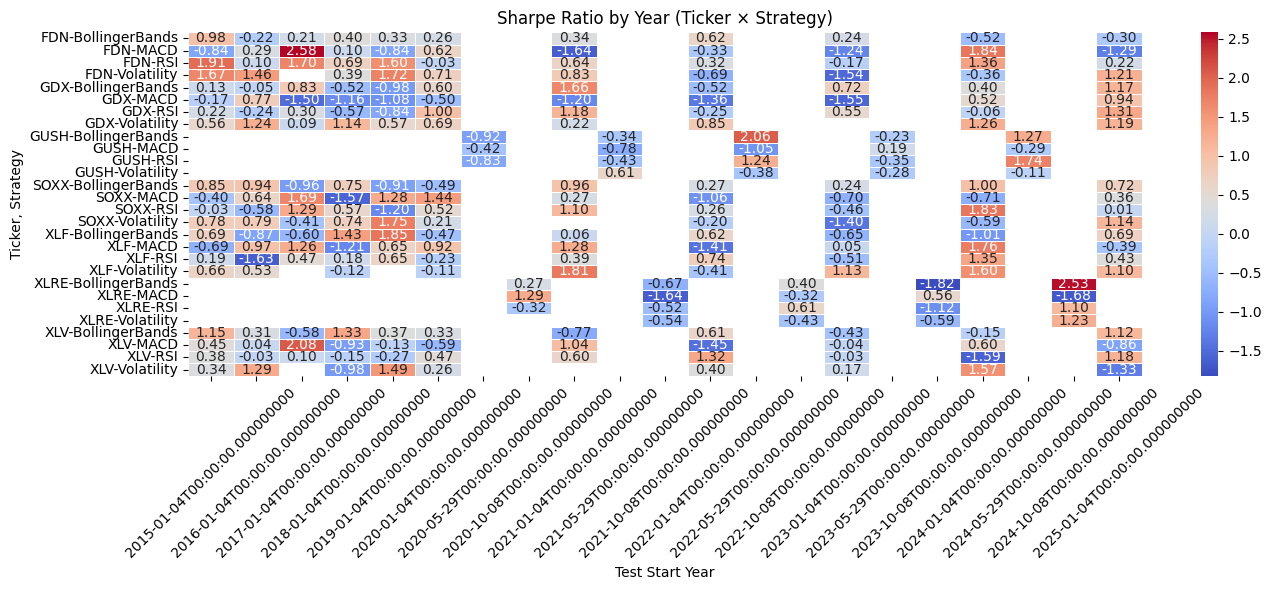

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))
sns.heatmap(sharpe_pivot, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title("Sharpe Ratio by Year (Ticker × Strategy)")
plt.xlabel("Test Start Year")
plt.ylabel("Ticker, Strategy")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


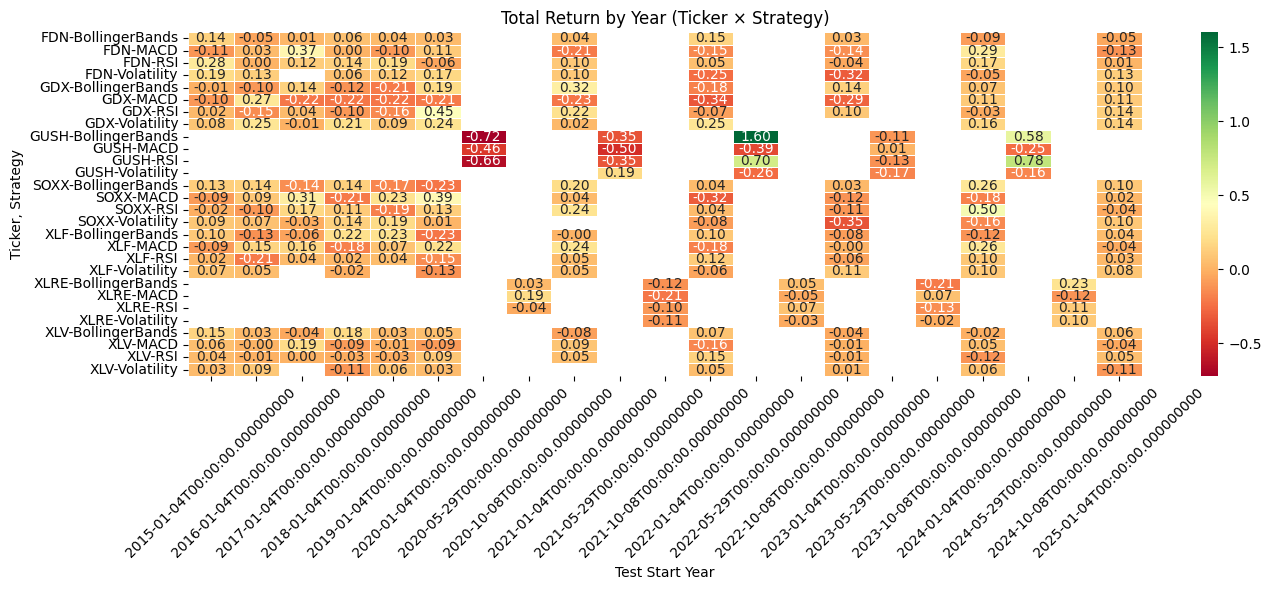

In [ ]:
plt.figure(figsize=(14, 6))
sns.heatmap(return_pivot, cmap='RdYlGn', annot=True, fmt=".2f", linewidths=0.5)
plt.title("Total Return by Year (Ticker × Strategy)")
plt.xlabel("Test Start Year")
plt.ylabel("Ticker, Strategy")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
returns_pivot = results_op.pivot_table(
    index=['Ticker', 'test_start'],
    columns='Strategy',
    values='Total Return'
)

In [ ]:
# Compute correlation matrix
strategy_corr = returns_pivot.corr().round(3)

In [ ]:
strategy_corr

Strategy,BollingerBands,MACD,RSI,Volatility
Strategy,,,,
BollingerBands,1.000,-0.228,0.772,-0.344
MACD,-0.228,1.000,-0.062,0.122
RSI,0.772,-0.062,1.000,-0.240
Volatility,-0.344,0.122,-0.240,1.000


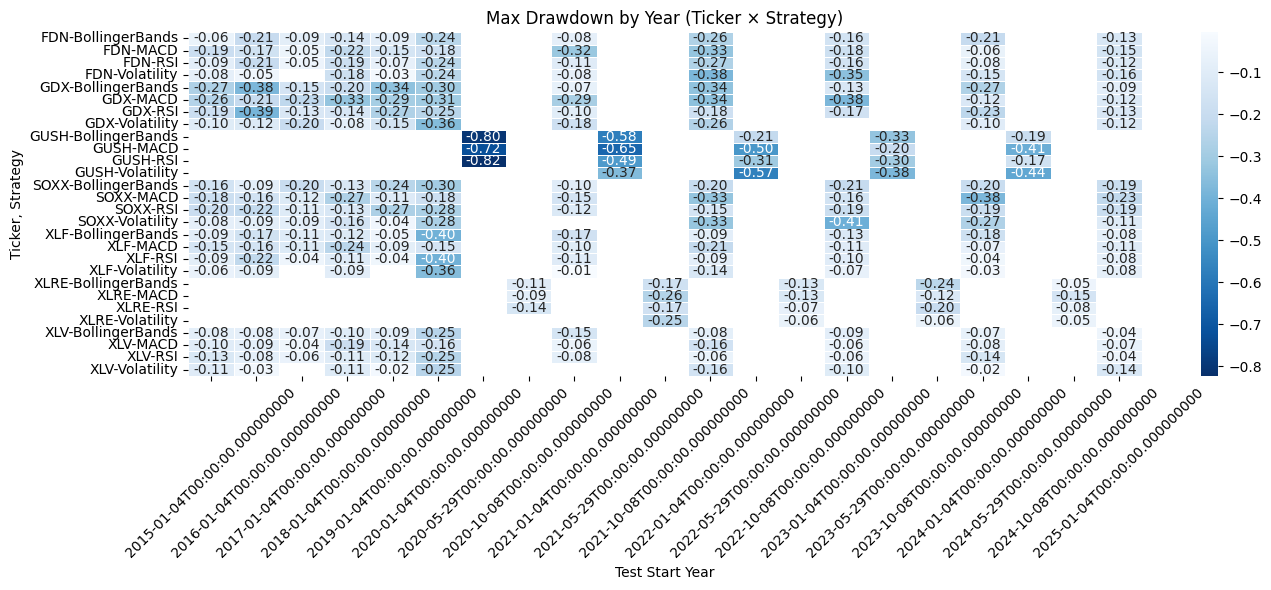

In [ ]:
plt.figure(figsize=(14, 6))
sns.heatmap(drawdown_pivot, cmap='Blues_r', annot=True, fmt=".2f", linewidths=0.5)
plt.title("Max Drawdown by Year (Ticker × Strategy)")
plt.xlabel("Test Start Year")
plt.ylabel("Ticker, Strategy")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()